In [11]:
import xarray as xr 
import clix
import pandas as pd

INFO:root:Using clix cache dir at: /tmp/dask_
INFO:root:Using dask cache dir at: /tmp/dask_
/Users/aidanstarr/miniforge3/envs/productivity_loss_v2/lib/python3.10/site-packages/clix/aggregation_interpolation.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/aidanstarr/miniforge3/envs/productivity_loss_v2/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [110]:
fn = '../data/sample_assets.csv'
loss_function = 'HOTHAPS'


## read csv  
df_in = pd.read_csv(fn)[['asset_id','latitude','longitude','asset_type']]
df_in = df_in.drop_duplicates('asset_id')
## load asset map 
asset_map = pd.read_csv('../src/asset_map.csv')

## load aircon
aircon = xr.open_zarr('s3://hazard-science-data/productivity_loss_v2/aircon/AirCon_SSPs.zarr/') 
aircon = aircon.sel(SSP='2.0').isel(year=0)['ac_penetration']

## load losses
ds_dict = {}
for scenario in ['ssp126','ssp245','ssp370','ssp585']:
    ds_dict[scenario] = {}
    for intensity in ['low','moderate','high']:
        ds_dict[scenario][intensity] = xr.open_zarr(f"s3://hazard-science-data/productivity_loss_v2/climate_outputs/projections_corrected/{scenario}/CMIP6-ScenarioMIP_{loss_function}_productivity_loss_{intensity}_{scenario}.zarr.zarr/")

In [ ]:
## output
df_out = df_in.copy(deep=True).set_index('asset_id')
df_out['work_intensity'] = df_out['asset_type'].map(asset_map.set_index('asset_type').to_dict()['intensity'])

## sample
df_out_ssp126 = df_out.copy(deep=True)


In [123]:
for asset in df_out.index[:-4]:
    intensity = df_out.loc[asset,'work_intensity']
    ds_ = ds_dict['ssp585'][intensity].sel(lat=df_out.loc[asset,'latitude'],lon=df_out.loc[asset,'longitude'],method='nearest')


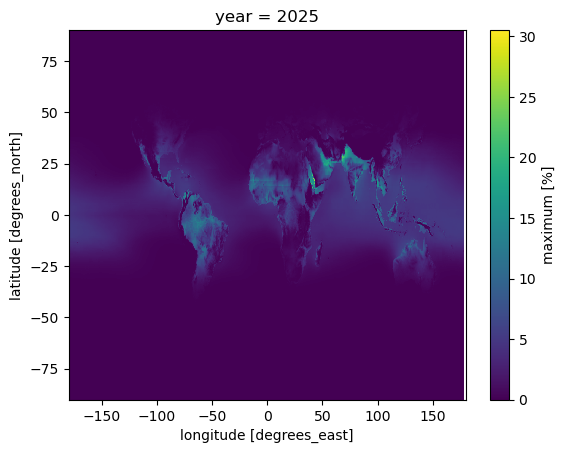

In [139]:
ds_dict['ssp585']['high'].isel(year=0)['maximum'].plot()
